### This program tries to make a very basic object detector ###


In [1]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io, transform, exposure, filters, feature, color, data
import matplotlib.pyplot as plt
import argparse
import numpy as np

In [2]:
def imNormalize(image):
    image = np.float64(image)
    if len(image.shape)==2:
        r = image
        g = image
        b = image
    else:
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
    
    r = r - r.min()
    if r.max()!=0:
        r = r / r.max()
    r = np.uint8(r * 255)
    
    g = g - g.min()
    if g.max()!=0:
        g = g / g.max()
    g = np.uint8(g * 255)
    
    b = b - b.min()
    if b.max()!=0:
        b = b / b.max()
    b = np.uint8(b * 255)
    
    return np.stack((r,g,b),axis=2) 


def colorHistogram(image):
    image = imNormalize(image)
    if np.amax(image) == 0:
        image = image + np.random.randint(0,256,image.shape)
    temp = exposure.histogram(image, channel_axis=2)
    h = np.concatenate((temp[0][0],temp[0][1],temp[0][2]), axis = None)
    
    return h

In [3]:
def getboxes(image,n_boxes = 25, min_width=10, min_height=10, padding=0, min_ratio=0.5, max_ratio=2):
    coords = np.zeros([n_boxes,4],'int16')#[r1,c1,r2,c2]
    height = image.shape[0]
    width = image.shape[1]
    for i in range(n_boxes):
        ratio = 0
        while((min_ratio>ratio) or (ratio>max_ratio)):
            r1 = np.random.randint(0+padding, height - min_height-padding)
            c1 = np.random.randint(0+padding, width - min_width-padding)
            r2 = np.random.randint(r1 + min_height - 1, height-padding)
            c2 = np.random.randint(c1 + min_width - 1, width-padding)
            ratio = (c2 - c1) / (r2 - r1)
            coords[i,:] = [r1, c1, r2, c2]
    return coords


def drawbox(image, r1, c1, r2, c2, color=[255,255,0], linewidth = 1):
    if len(image.shape)==2:
        r = image
        g = image
        b = image
        image = np.stack((r,g,b),axis=2) 
    
    mask = np.zeros([r2-r1, c2-c1, 3],'uint8')
    for plane in range(3):
        mask[:,:,plane] = color[plane]
    image2 = np.copy(image)
    image2[r1:r2, c1:c2, :] = mask
    image2[r1+linewidth:r2-linewidth, c1+linewidth:c2-linewidth, :] = image[r1+linewidth:r2-linewidth, c1+linewidth:c2-linewidth, :]
    return image2

In [4]:
def getsaliency(patch):
    scales = 10
    bwpatch = color.rgb2gray(patch)
    score = np.zeros(bwpatch.shape)
    outputs = np.zeros([bwpatch.shape[0], bwpatch.shape[1], scales])
    
    for i in range(scales):
        outputs[:,:,i] = filters.gaussian(bwpatch, sigma=2**(-i), mode='constant',truncate=3)
    
    for i in range(scales-1):
        score += outputs[:,:,i]-outputs[:,:,i+1]
    score = np.abs(score-np.mean(score))
    return np.sum(score)/(bwpatch.shape[0]*bwpatch.shape[1])


In [5]:
#### Testing code ####


# image = data.astronaut()
# s = getsaliency(image)
# print(s)

# windows = getboxes(image,5)
# scores = []

# image2 = np.copy(image)
# for i in range(windows.shape[0]):
#     image2 = drawbox(image2, windows[i,0],windows[i,1],windows[i,2],windows[i,3],linewidth=4,color=[50,200,200])
#     scores.append(getsaliency(image[windows[i,0]:windows[i,2],windows[i,1]:windows[i,3],:]))

# print(scores)
# io.imshow(image2)

In [6]:
def cityblock_distance(a, b):
    return np.sum(np.abs(a-b))

In [7]:
def colorcontrast(image, r1, c1, r2, c2, padding=10):
    innerpatch = np.copy(image[r1:r2, c1:c2, :])
    outerpatch = np.copy(image[r1-padding:r2+padding, c1-padding:c2+padding, :])
    inner_h = colorHistogram(innerpatch)
    inner_area = np.float64(r2-r1) * np.float64(c2-c1)
    inner_h = np.float64(inner_h) / inner_area
    outerpatch[padding:-padding, padding:-padding, :] = 0
    outer_h = colorHistogram(outerpatch)
    outer_area = np.float64(r2-r1+2*padding)*np.float64(c2-c1+2*padding) - inner_area
    outer_h = np.float64(outer_h) / outer_area
    inner_h[0] = 0
    inner_h[256] = 0
    inner_h[512] = 0
    outer_h[0] = 0
    outer_h[256] = 0
    outer_h[512] = 0
    return cityblock_distance(inner_h, outer_h)

In [8]:
## testing code

# image = data.astronaut()
# windows = getboxes(image,5, padding=25)
# scores = []

# image2 = np.copy(image)
# for i in range(windows.shape[0]):
#     image2 = drawbox(image2, windows[i,0],windows[i,1],windows[i,2],windows[i,3],linewidth=4,color=[50,200,200])
#     scores.append(colorcontrast(image,windows[i,0],windows[i,1],windows[i,2],windows[i,3],25))

# print(scores)
# io.imshow(image2)

In [9]:
def edgedensity(patch, padding=10):
    patch = color.rgb2gray(patch)
    innerpatch = patch[padding:-padding, padding:-padding]
    inner_area = (patch.shape[0]-2*padding) * (patch.shape[1]-2*padding)
    inneredges = feature.canny(innerpatch)
    outerring = np.copy(patch)
    outerring[padding:-padding, padding:-padding] = 0
    outeredges = feature.canny(outerring)
    outer_area = patch.shape[0]*patch.shape[1]
    
    inner_ed = np.sum(inneredges)/inner_area
    outer_ed = np.sum(outeredges)/outer_area
    
    return outer_ed - inner_ed

In [10]:
## testing code

# image = data.astronaut()
# windows = getboxes(image,5, min_width=50, min_height=50,padding=10)
# scores = []

# image2 = np.copy(image)
# for i in range(windows.shape[0]):
#     image2 = drawbox(image2, windows[i,0],windows[i,1],windows[i,2],windows[i,3],linewidth=4,color=[50,200,200])
#     scores.append(edgedensity(image[windows[i,0]:windows[i,2],windows[i,1]:windows[i,3],:]))

# print(scores)
# io.imshow(image2)

In [11]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float


def straddling(image, r1, c1, r2, c2):
    numSegments = 500
    image = img_as_float(image)
    # loop over the number of segments
    # apply SLIC and extract (approximately) the supplied number
    # of segments
    segments = slic(image, n_segments = numSegments, sigma = 10)
    # # show the output of SLIC
    # fig = plt.figure(figsize=(8,8))
    # ax = fig.add_subplot(1, 1, 1)
    # ax.imshow(mark_boundaries(image, segments))
    # plt.axis("off")
    # # show the plots
    # plt.show()
    count = 0
    patch = segments[r1:r2, c1:c2]
    patch[1:-1,1:-1] = 0
    values = set(list(patch.ravel()))
    return len(values)-1 # don't count 0 

In [12]:
# # Testing code

# image = data.astronaut()
# windows = getboxes(image,5, min_width=50, min_height=50,padding=10)
# scores = []

# image2 = np.copy(image)
# for i in range(windows.shape[0]):
#     image2 = drawbox(image2, windows[i,0],windows[i,1],windows[i,2],windows[i,3],linewidth=4,color=[50,200,200])
#     scores.append(straddling(image,windows[i,0],windows[i,1],windows[i,2],windows[i,3]))

# print(scores)
# io.imshow(image2)

In [13]:
def objectness(image, r1, c1, r2, c2):
    output = np.zeros(4)
    output[0] = getsaliency(image[r1:r2,c1:c2,:])
    output[1] = colorcontrast(image, r1, c1, r2, c2, padding=10)
    output[2] = edgedensity(image[r1:r2,c1:c2,:], padding=10)
    output[3] = straddling(image, r1, c1, r2, c2)
    return output

In [14]:
import os

path = 'c:/work/data/caltech-101/101_ObjectCategories'
classes = os.listdir(path)
classes

newlist = []
for item in classes:
    try:
        os.listdir(path+'/'+item)
        newlist.append(item)
    except:
        continue
classes = newlist
classes

['accordion',
 'airplanes',
 'anchor',
 'ant',
 'BACKGROUND_Google',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'Faces',
 'Faces_easy',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'Leopards',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'Motorbikes',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooste

In [15]:
ourclassnums = np.random.choice(len(classes), 10)


In [16]:
features = []
filenames = []
boxnums = []



# Read objectness from all samples
for classnum in ourclassnums:
    folder = path + '/' + classes[classnum]
    print(classes[classnum], end='')
    filelist = os.listdir(folder)
    #np.random.shuffle(filelist)
    for i in range(len(filelist)):
        filename = folder + '/' + filelist[i]
        print('.',end='')
        if filelist[i].upper()=='THUMBS.DB':
            continue
        image = io.imread(filename)
        image = imNormalize(image)
        
        # boxes = grid(image,128,64)
        boxes = getboxes(image,10,min_height=50, min_width=50,min_ratio = 0.25, max_ratio=4,padding=20)
        for b in range(boxes.shape[0]):
            r1 = boxes[b,0]
            c1 = boxes[b,1]
            r2 = boxes[b,2]
            c2 = boxes[b,3]
            fd = objectness(image,r1,c1,r2,c2)
            filenames.append(filename)
            features.append(fd)
            boxnums.append(boxes[b,:])
    print()
        
features = np.array(features)
boxnums = np.array(boxnums)
features.shape

chair..............................................................
car_side...........................................................................................................................
airplanes.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

(14290, 4)

In [22]:
from sklearn.cluster import KMeans

no_of_clusters = 2
model1 = KMeans(no_of_clusters)
model1.fit(features)


KMeans(n_clusters=5)

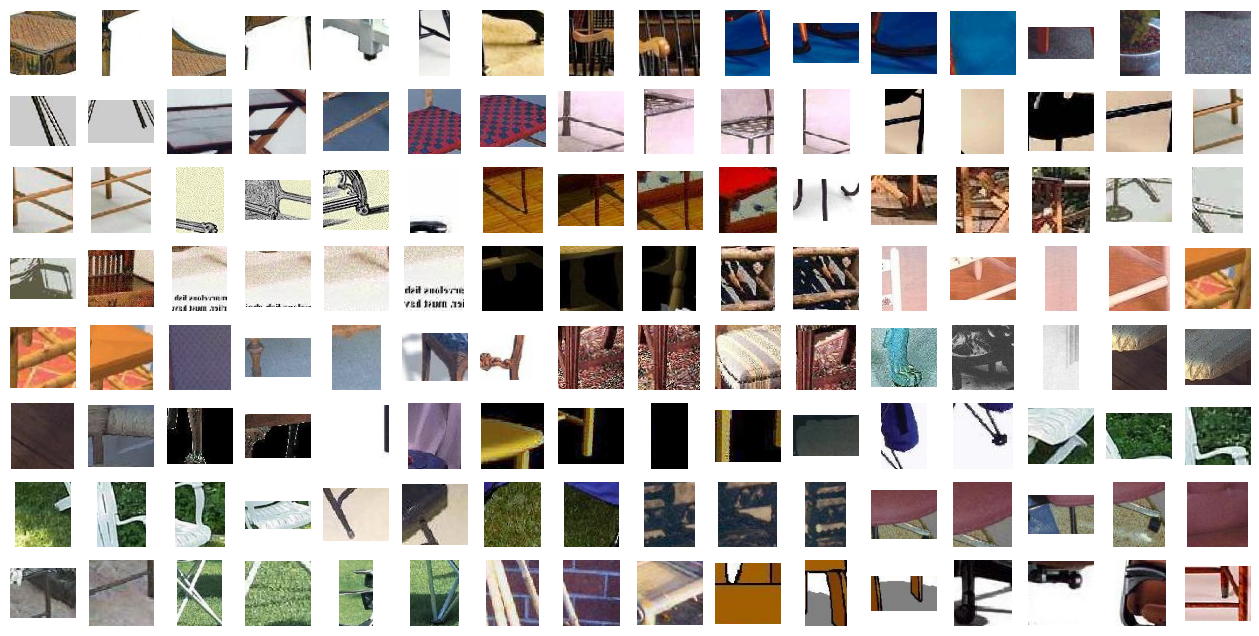

In [23]:
count = 0

fig=plt.figure(figsize=(16, 8))

columns = 16
rows = 8
cluster_we_need_to_see = 0

for row in range(len(filenames)):
    if model1.labels_[row] == cluster_we_need_to_see:
        count = count + 1
        image = io.imread(filenames[row])
        image = imNormalize(image)
        
        box = boxnums[row,:]
        r1 = box[0]
        c1 = box[1]
        r2 = box[2]
        c2 = box[3]
        patch = image[r1:r2,c1:c2]
        
        fig.add_subplot(rows, columns, count)
        plt.imshow(patch)
        plt.axis('off')
        
    if count == rows * columns:
        break
plt.show()

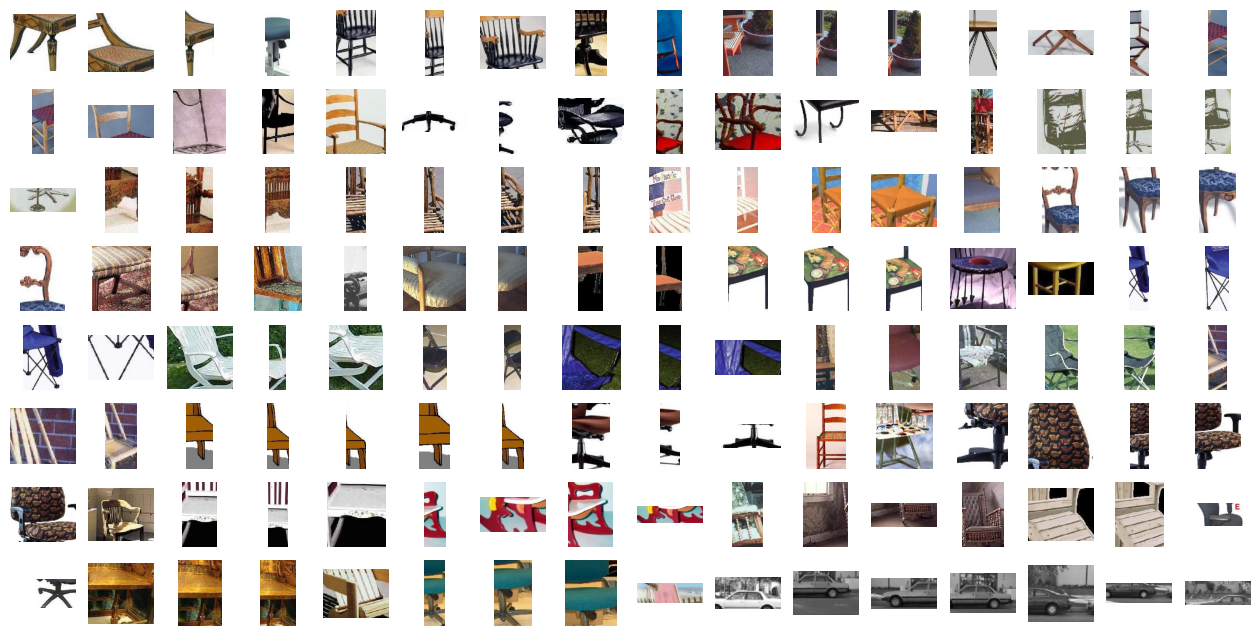

In [24]:
count = 0

fig=plt.figure(figsize=(16, 8))

columns = 16
rows = 8
cluster_we_need_to_see = 1

for row in range(len(filenames)):
    if model1.labels_[row] == cluster_we_need_to_see:
        count = count + 1
        image = io.imread(filenames[row])
        image = imNormalize(image)
        
        box = boxnums[row,:]
        r1 = box[0]
        c1 = box[1]
        r2 = box[2]
        c2 = box[3]
        patch = image[r1:r2,c1:c2]
        
        fig.add_subplot(rows, columns, count)
        plt.imshow(patch)
        plt.axis('off')
        
    if count == rows * columns:
        break
plt.show()

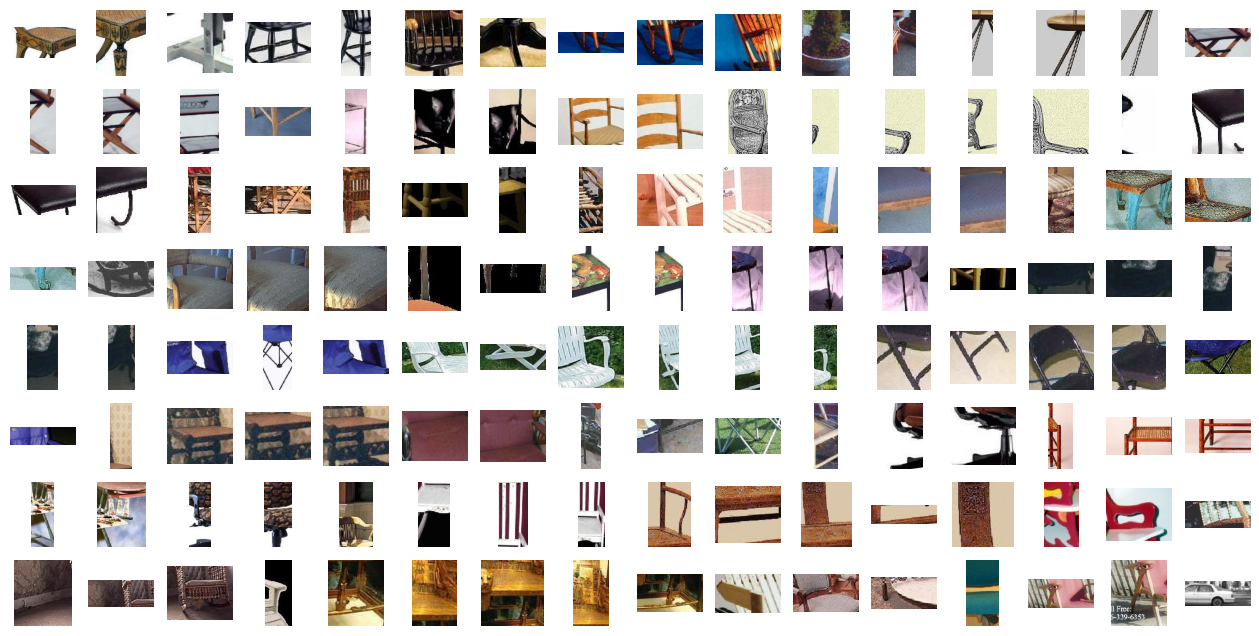

In [27]:
count = 0

fig=plt.figure(figsize=(16, 8))

columns = 16
rows = 8
cluster_we_need_to_see = 4

for row in range(len(filenames)):
    if model1.labels_[row] == cluster_we_need_to_see:
        count = count + 1
        image = io.imread(filenames[row])
        image = imNormalize(image)
        
        box = boxnums[row,:]
        r1 = box[0]
        c1 = box[1]
        r2 = box[2]
        c2 = box[3]
        patch = image[r1:r2,c1:c2]
        
        fig.add_subplot(rows, columns, count)
        plt.imshow(patch)
        plt.axis('off')
        
    if count == rows * columns:
        break
plt.show()